In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pathlib

# Define the dataset path
data_dir = pathlib.Path('/content/drive/My Drive/trainingData/trainingData')


In [4]:
# Check contents of the dataset
print("Classes in the dataset:")
for folder in data_dir.iterdir():
    print(folder.name, "->", len(list(folder.glob('*'))), "images")


Classes in the dataset:
K -> 30 images
G -> 68 images
H -> 48 images
M -> 41 images


In [5]:
import matplotlib.pyplot as plt
from PIL import Image
import pathlib

In [6]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import pathlib

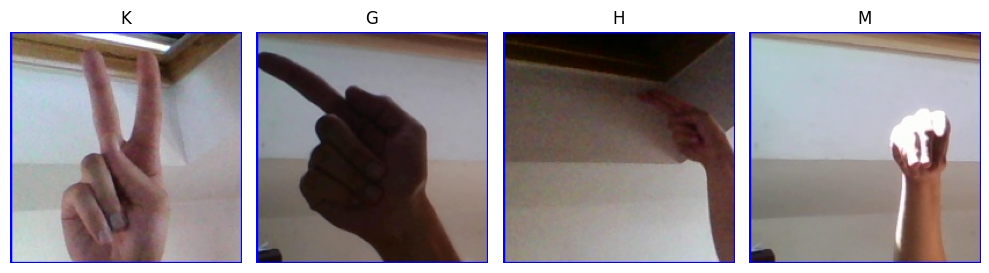

In [7]:
# Get one image from each folder
classes = ['K', 'G', 'H', 'M']
images = {cls: list(data_dir.glob(f'{cls}/*'))[0] for cls in classes}

# Plot the images
plt.figure(figsize=(10, 5))
for i, (cls, img_path) in enumerate(images.items()):
    img = Image.open(img_path)
    plt.subplot(1, 4, i + 1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis('off')

plt.tight_layout()
plt.show()

Class Distribution: {'K': 30, 'G': 68, 'H': 48, 'M': 41}


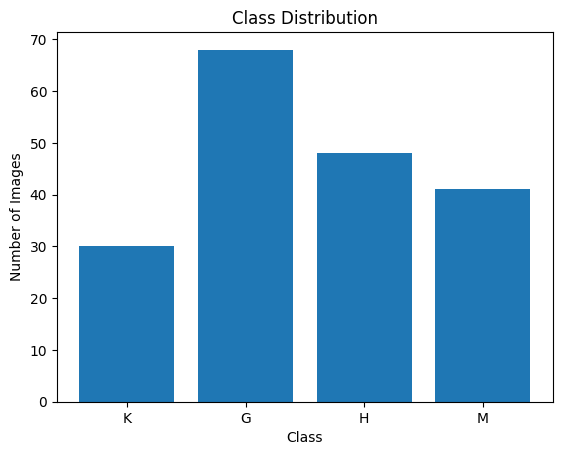

In [8]:
import collections

# Count the number of images per class
class_counts = {cls.name: len(list(cls.glob('*'))) for cls in data_dir.iterdir()}
print("Class Distribution:", class_counts)

# Visualize class distribution
plt.bar(class_counts.keys(), class_counts.values())
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

In [9]:
from PIL import Image

for cls in classes:
    cls_images = list(data_dir.glob(f'{cls}/*'))
    resolutions = [Image.open(img).size for img in cls_images]
    print(f"{cls}: Resolutions - {collections.Counter(resolutions)}")

K: Resolutions - Counter({(200, 200): 30})
G: Resolutions - Counter({(200, 200): 68})
H: Resolutions - Counter({(200, 200): 48})
M: Resolutions - Counter({(200, 200): 41})


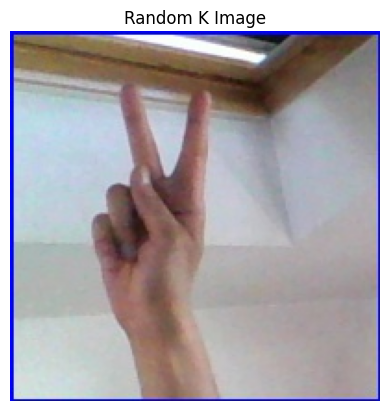

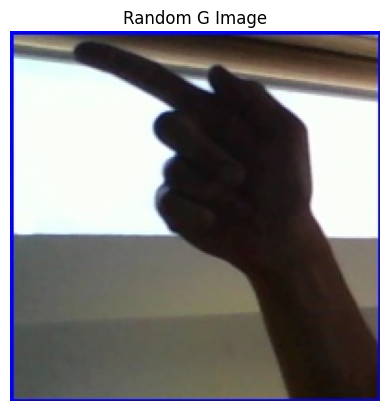

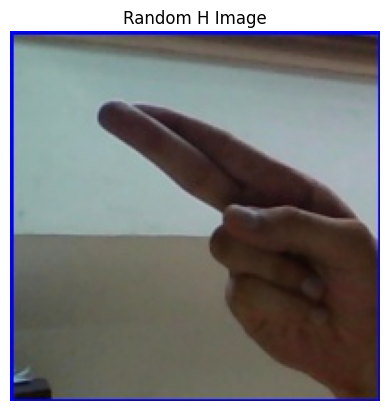

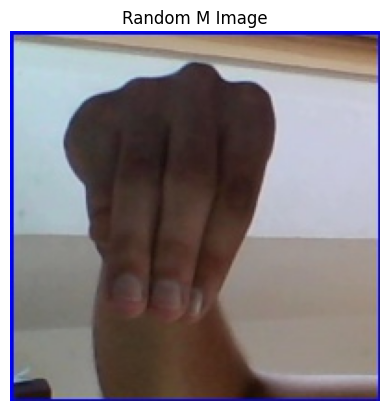

In [10]:
import random

# Display random images to inspect illumination
for cls in classes:
    random_image = random.choice(list(data_dir.glob(f'{cls}/*')))
    img = Image.open(random_image)
    plt.imshow(img)
    plt.title(f"Random {cls} Image")
    plt.axis('off')
    plt.show()


In [11]:
#Data Augmentation
data_gen = ImageDataGenerator(
    rescale=1.0 / 255,  # Normalize pixel values
    rotation_range=15,  # Increase rotation range
    width_shift_range=0.15,  # Increase horizontal shift
    height_shift_range=0.15,  # Increase vertical shift
    brightness_range=[0.7, 1.3],  # Wider brightness adjustment
    shear_range=0.25,  # Slightly increased shear transformations
    zoom_range=0.25,  # Slightly increased zoom range
    validation_split=0.2  # Split into training and validation
)

# Training and Validation Generators
train_data = data_gen.flow_from_directory(
    directory=str(data_dir),
    target_size=(300, 300),  # Larger resolution for EfficientNetB0
    batch_size=32,
    class_mode='categorical',
    subset='training'
)
val_data = data_gen.flow_from_directory(
    directory=str(data_dir),
    target_size=(300, 300),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Compute Class Weights
class_counts = [30, 68, 48, 41]  # Replace with your actual class distribution
class_weight = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(class_counts)),
    y=np.concatenate([[i] * count for i, count in enumerate(class_counts)])
)
class_weight_dict = dict(enumerate(class_weight))
print("Class Weights:", class_weight_dict)

Found 151 images belonging to 4 classes.
Found 36 images belonging to 4 classes.
Class Weights: {0: 1.5583333333333333, 1: 0.6875, 2: 0.9739583333333334, 3: 1.1402439024390243}


In [12]:
#EfficientNetB0
from tensorflow.keras.applications import EfficientNetB0
# Load EfficientNetB0
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(300, 300, 3))

# Add Custom Layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # Increased dropout to prevent overfitting
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)  # 4 classes: K, G, H, M

# Create the Full Model
model = Model(inputs=base_model.input, outputs=predictions)
# Freeze Base Model Layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the Model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
# Train the Model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=25,
    class_weight=class_weight_dict,
    callbacks=[early_stopping]
)

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 60s 7s/step - accuracy: 0.3591 - loss: 1.5001 - val_accuracy: 0.3611 - val_loss: 1.4151
Epoch 2/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 37s 389ms/step - accuracy: 0.3766 - loss: 1.4217 - val_accuracy: 0.3611 - val_loss: 1.4722
Epoch 3/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 398ms/step - accuracy: 0.3347 - loss: 1.5150 - val_accuracy: 0.3611 - val_loss: 1.3842
Epoch 4/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 367ms/step - accuracy: 0.3443 - loss: 1.4812 - val_accuracy: 0.3611 - val_loss: 1.3767
Epoch 5/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 386ms/step - accuracy: 0.3767 - loss: 1.4884 - val_accuracy: 0.3611 - val_loss: 1.3848
Epoch 6/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 378ms/step - accuracy: 0.3388 - loss: 1.4692 - val_accuracy: 0.3611 - val_loss: 1.3782
Epoch 7/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 393ms/step - accuracy: 0.3669 - loss: 1.4643 - val_accuracy: 0.3611 - val_loss: 1.3815
Epoch 8/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 308ms/step - accuracy: 0.3872 - loss: 1.4089 - val_accuracy: 0.3611 - val_loss: 1.3874
Ep

In [14]:
 #Unfreeze the Top Layers for Fine-Tuning
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Recompile with a Lower Learning Rate for Fine-Tuning
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-Tune
history_fine_tune = model.fit(
    train_data,
    validation_data=val_data,
    epochs=15,
    class_weight=class_weight_dict,
    callbacks=[early_stopping]
)


Epoch 1/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 57s 7s/step - accuracy: 0.2779 - loss: 1.8950 - val_accuracy: 0.3611 - val_loss: 1.3816
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 300ms/step - accuracy: 0.3097 - loss: 1.5104 - val_accuracy: 0.3611 - val_loss: 1.3890
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 387ms/step - accuracy: 0.3895 - loss: 1.4390 - val_accuracy: 0.3611 - val_loss: 1.3967
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 305ms/step - accuracy: 0.3792 - loss: 1.4354 - val_accuracy: 0.3611 - val_loss: 1.4046
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 300ms/step - accuracy: 0.3907 - loss: 1.4913 - val_accuracy: 0.3611 - val_loss: 1.4133
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 399ms/step - accuracy: 0.3685 - loss: 1.4593 - val_accuracy: 0.3611 - val_loss: 1.4193
Epoch 7/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 307ms/step - accuracy: 0.3796 - loss: 1.4268 - val_accuracy: 0.3611 - val_loss: 1.4231


In [15]:
# Save the Model
model.save('/content/drive/My Drive/EfficientNetB0_sign_model.h5')

# Evaluate on Validation Data
val_loss, val_accuracy = model.evaluate(val_data)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.3449 - loss: 1.3999
Validation Loss: 1.3813990354537964
Validation Accuracy: 0.3611111044883728


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


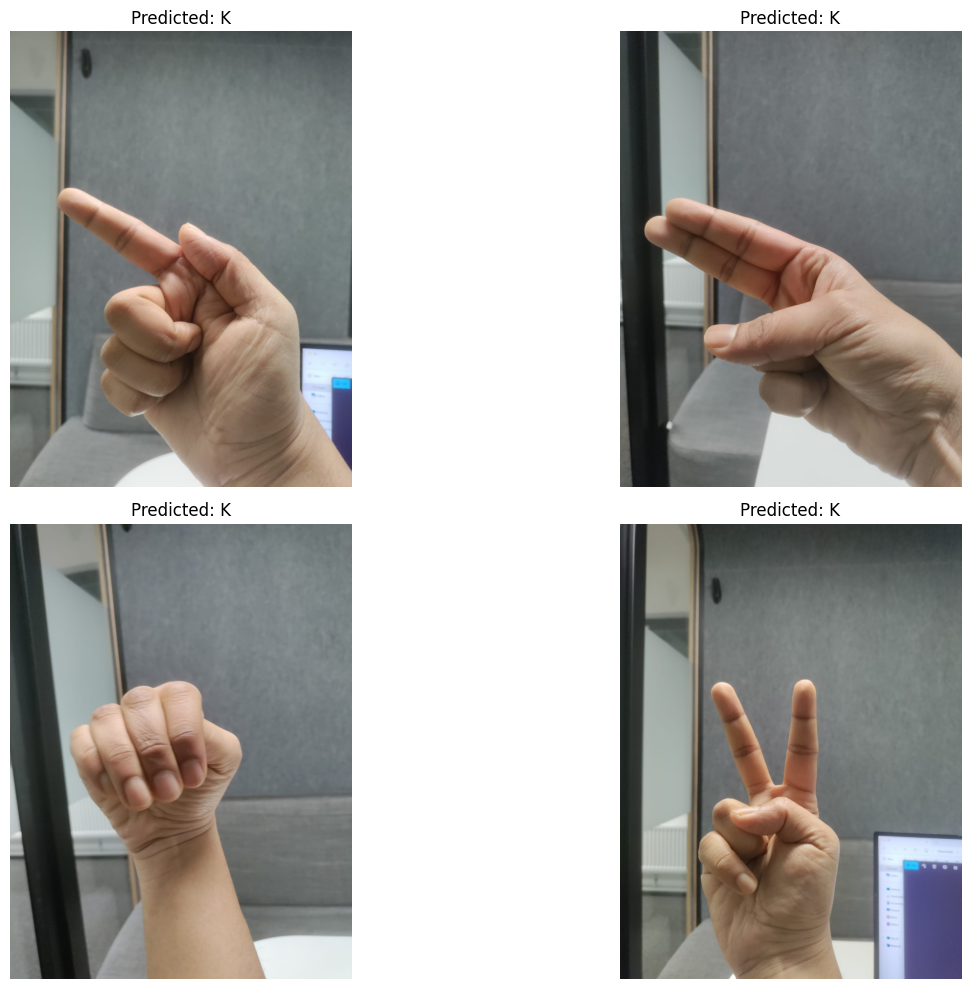

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.models import load_model

# Load the trained model
model_path = '/content/drive/My Drive/EfficientNetB0_sign_model.h5'  # Update path if needed
model = load_model(model_path)

# Test image paths (update these paths to your test images)
image_paths = [
    '/content/drive/My Drive/trainingData/test/1.jpeg',  # Replace with actual paths
    '/content/drive/My Drive/trainingData/test/2.jpeg',
    '/content/drive/My Drive/trainingData/test/3.jpeg',
    '/content/drive/My Drive/trainingData/test/4.jpeg'
]

# Class labels (update based on your training classes)
class_indices = {'K': 0, 'G': 1, 'H': 2, 'M': 3}  # Replace with your class-to-index mapping
class_labels = {v: k for k, v in class_indices.items()}  # Reverse mapping for predictions

# Function to preprocess test images
def load_and_preprocess_image(image_path):
    img = Image.open(image_path).convert("RGB").resize((300, 300))  # Resize and ensure RGB
    img_array = np.array(img) / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Predict and visualize
plt.figure(figsize=(15, 10))

for i, image_path in enumerate(image_paths):
    # Preprocess image
    img_array = load_and_preprocess_image(image_path)
    # Predict class probabilities
    predictions = model.predict(img_array)
    # Get predicted class index
    predicted_class = np.argmax(predictions)

    # Plot the image and its prediction
    plt.subplot(2, 2, i + 1)
    img = Image.open(image_path)
    plt.imshow(img)
    plt.title(f"Predicted: {class_labels[predicted_class]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [17]:
from tensorflow.keras.applications import DenseNet121
# Data Augmentation
data_gen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    brightness_range=[0.7, 1.3],
    shear_range=0.25,
    zoom_range=0.25,
    validation_split=0.2
)

# Training and Validation Generators
train_data = data_gen.flow_from_directory(
    directory=str(data_dir),
    target_size=(224, 224),  # Input size for DenseNet121
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_data = data_gen.flow_from_directory(
    directory=str(data_dir),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Compute Class Weights
class_counts = [30, 68, 48, 41]  # Replace with your actual class distribution
class_weight = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(class_counts)),
    y=np.concatenate([[i] * count for i, count in enumerate(class_counts)])
)
class_weight_dict = dict(enumerate(class_weight))

# Load DenseNet121
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add Custom Layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
predictions = Dense(4, activation='softmax')(x)

# Create the Full Model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze Base Model Layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the Model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Train the Model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=25,
    class_weight=class_weight_dict,
    callbacks=[early_stopping]
)

Found 151 images belonging to 4 classes.
Found 36 images belonging to 4 classes.
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 58s 8s/step - accuracy: 0.3036 - loss: 2.0845 - val_accuracy: 0.3611 - val_loss: 1.4202
Epoch 2/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 274ms/step - accuracy: 0.4060 - loss: 1.6036 - val_accuracy: 0.3889 - val_loss: 1.3028
Epoch 3/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 278ms/step - accuracy: 0.4242 - loss: 1.2641 - val_accuracy: 0.5833 - val_loss: 1.1540
Epoch 4/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 268ms/step - accuracy: 0.4531 - loss: 1.3053 - val_accuracy: 0.5278 - val_loss: 1.1040
Epoch 5/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 268ms/step - accuracy: 0.6420 - loss: 0.9960 - val_accuracy: 0.5278 - val_loss: 1.0551
Epoch 6/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 231ms/step - accuracy: 0.5601 - loss: 1.0222 - val_accuracy: 0.4167 - val_loss: 1.1089
Epoch 7/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 266ms/step - accuracy: 0.5693 - loss: 0.9483 - val_accuracy: 0.5556 - val_loss: 0.9654
Epoch 8/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 225ms/step - accuracy: 0.6566 - loss: 0.7790 - val_accuracy: 0.6389 - val_loss: 0.9661
Epoch

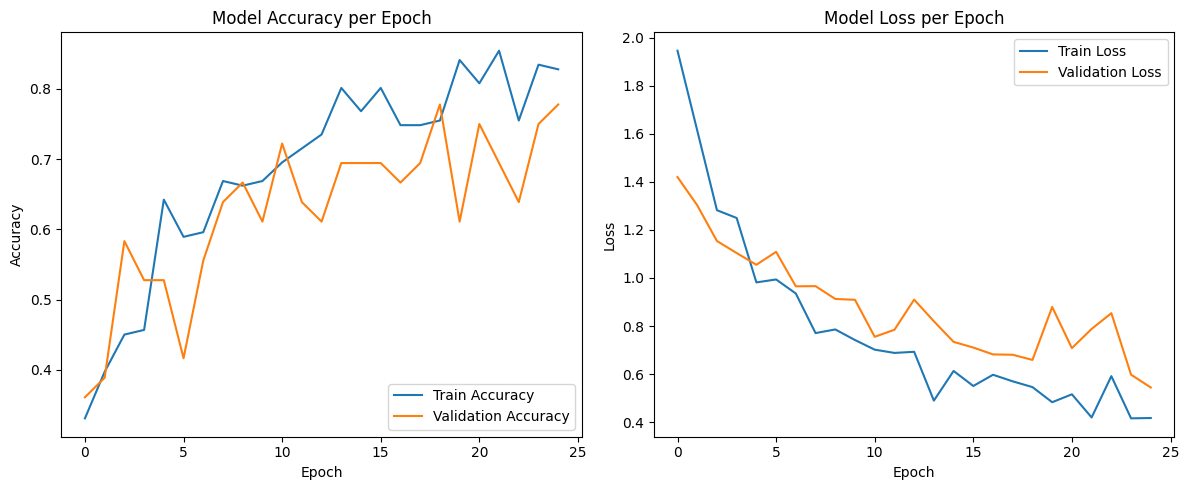

In [18]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [25]:
# Unfreeze the Top Layers for Fine-Tuning
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Recompile with a Lower Learning Rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-Tune
history_fine_tune = model.fit(
    train_data,
    validation_data=val_data,
    epochs=15,
    class_weight=class_weight_dict,
    callbacks=[early_stopping]
)

# Save the Model
model.save('/content/drive/My Drive/DenseNet121_sign_model.h5')

Epoch 1/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 51s 6s/step - accuracy: 0.8969 - loss: 0.3577 - val_accuracy: 0.8333 - val_loss: 0.3528
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 226ms/step - accuracy: 0.8852 - loss: 0.3248 - val_accuracy: 0.8889 - val_loss: 0.3387
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 250ms/step - accuracy: 0.8643 - loss: 0.3293 - val_accuracy: 0.8056 - val_loss: 0.4234
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 242ms/step - accuracy: 0.8987 - loss: 0.2989 - val_accuracy: 0.8889 - val_loss: 0.3835
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 411ms/step - accuracy: 0.9049 - loss: 0.2679 - val_accuracy: 0.8056 - val_loss: 0.3878
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 270ms/step - accuracy: 0.9032 - loss: 0.2548 - val_accuracy: 0.8333 - val_loss: 0.3061
Epoch 7/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 241ms/step - accuracy: 0.9144 - loss: 0.2071 - val_accuracy: 0.7778 - val_loss: 0.3923
Epoch 8/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 455ms/step - accuracy: 0.8812 - loss: 0.3275 - val_accuracy: 0.8889 - val_loss: 0

In [20]:
#TEST THE MODEL WITH MY OWN DATA

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


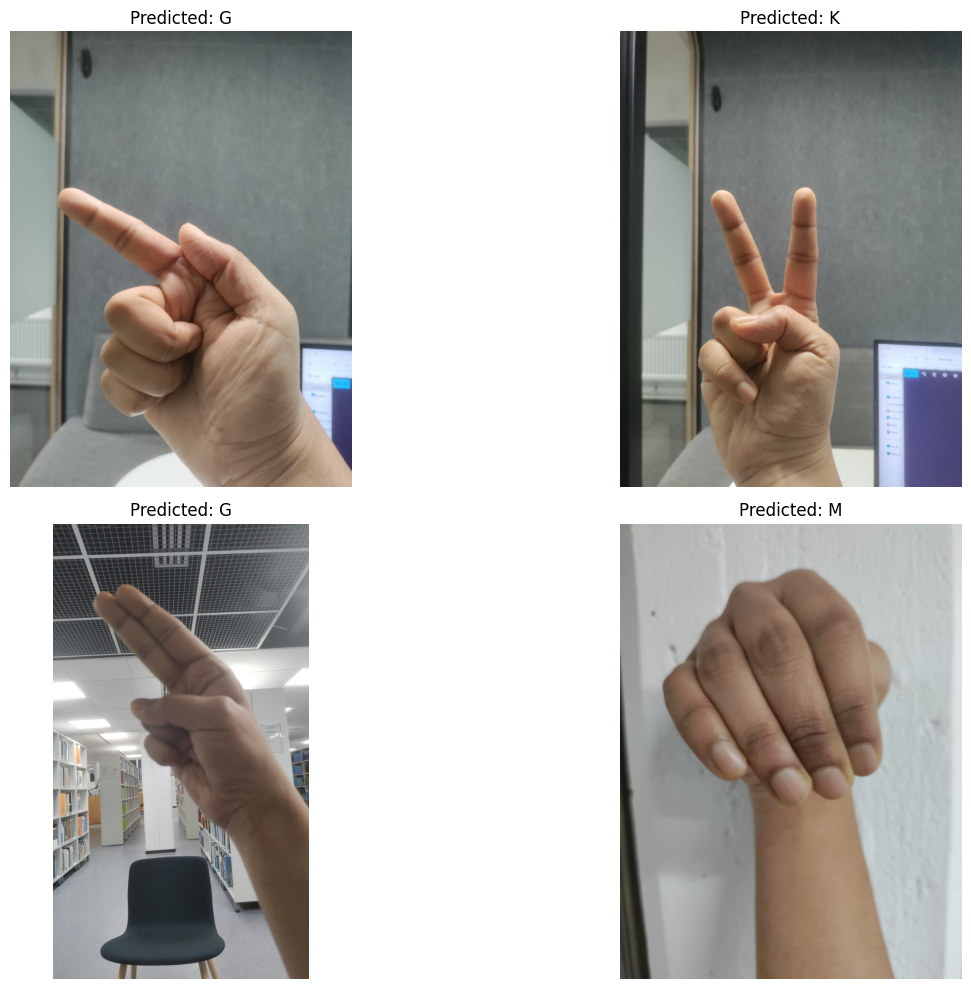

In [30]:
import numpy as np
from tensorflow.keras.models import load_model
from PIL import Image
import matplotlib.pyplot as plt

# Load the trained model
model_path = '/content/drive/My Drive/DenseNet121_sign_model.h5'  # Update to your model path
model = load_model(model_path)

# Test image paths (update these paths to your test images)
test_image_paths = [
    '/content/drive/My Drive/trainingData/test/1.jpeg',  # Replace with actual paths
    '/content/drive/My Drive/trainingData/test/4.jpeg',
    '/content/drive/My Drive/trainingData/test/h.jpeg',
    '/content/drive/My Drive/trainingData/test/6.jpeg'
]

# Class labels (update based on your training data)
class_indices = {'K': 2, 'G': 1, 'H': 0, 'M': 3}
class_labels = {v: k for k, v in class_indices.items()}  # Reverse mapping for predictions

# Function to preprocess images
def preprocess_image(image_path, target_size=(224, 224)):
    """Load and preprocess a single image."""
    img = Image.open(image_path).convert("RGB").resize(target_size)  # Ensure RGB and resize
    img_array = np.array(img) / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Evaluate each test image
plt.figure(figsize=(15, 10))

for i, image_path in enumerate(test_image_paths):
    # Preprocess image
    img_array = preprocess_image(image_path)

    # Get model predictions
    predictions = model.predict(img_array)
    predicted_class_idx = np.argmax(predictions)  # Get the predicted class index
    predicted_class_label = class_labels[predicted_class_idx]  # Map index to class label

    # Plot the image with its predicted label
    plt.subplot(2, 2, i + 1)
    img = Image.open(image_path)
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [22]:
#Augmentation importance

# Define data generators
data_gen_no_aug = ImageDataGenerator(rescale=1.0 / 255, validation_split=0.2)  # No augmentation
data_gen_with_aug = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.15,
    validation_split=0.2
)

# Load data
train_no_aug = data_gen_no_aug.flow_from_directory(
    directory=str(data_dir),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)
val_no_aug = data_gen_no_aug.flow_from_directory(
    directory=str(data_dir),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

train_with_aug = data_gen_with_aug.flow_from_directory(
    directory=str(data_dir),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)
val_with_aug = data_gen_with_aug.flow_from_directory(
    directory=str(data_dir),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Define a baseline model
def create_model():
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.4)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.4)(x)
    predictions = Dense(4, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Train model without augmentation
model_no_aug = create_model()
history_no_aug = model_no_aug.fit(
    train_no_aug,
    validation_data=val_no_aug,
    epochs=15,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

# Train model with augmentation
model_with_aug = create_model()
history_with_aug = model_with_aug.fit(
    train_with_aug,
    validation_data=val_with_aug,
    epochs=15,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

# Compare results
print("Model with augmentation:")
print(f"Validation Accuracy: {history_no_aug.history['val_accuracy'][-1]}")
print(f"Validation Loss: {history_no_aug.history['val_loss'][-1]}")

print("\nModel without augmentation:")
print(f"Validation Accuracy: {history_with_aug.history['val_accuracy'][-1]}")
print(f"Validation Loss: {history_with_aug.history['val_loss'][-1]}")


Found 151 images belonging to 4 classes.
Found 36 images belonging to 4 classes.
Found 151 images belonging to 4 classes.
Found 36 images belonging to 4 classes.
Epoch 1/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - accuracy: 0.2906 - loss: 1.8188 - val_accuracy: 0.3889 - val_loss: 1.2222
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 189ms/step - accuracy: 0.3838 - loss: 1.3551 - val_accuracy: 0.6667 - val_loss: 0.9446
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step - accuracy: 0.5359 - loss: 1.0688 - val_accuracy: 0.7500 - val_loss: 0.8086
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - accuracy: 0.6658 - loss: 0.8255 - val_accuracy: 0.6944 - val_loss: 0.7428
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 217ms/step - accuracy: 0.7415 - loss: 0.7040 - val_accuracy: 0.7222 - val_loss: 0.6377
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.7812 - loss: 0.5682 - val_accuracy: 0.7500 - val_loss: 0.5619
Epoch 7/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.8073 - loss: 0.4723

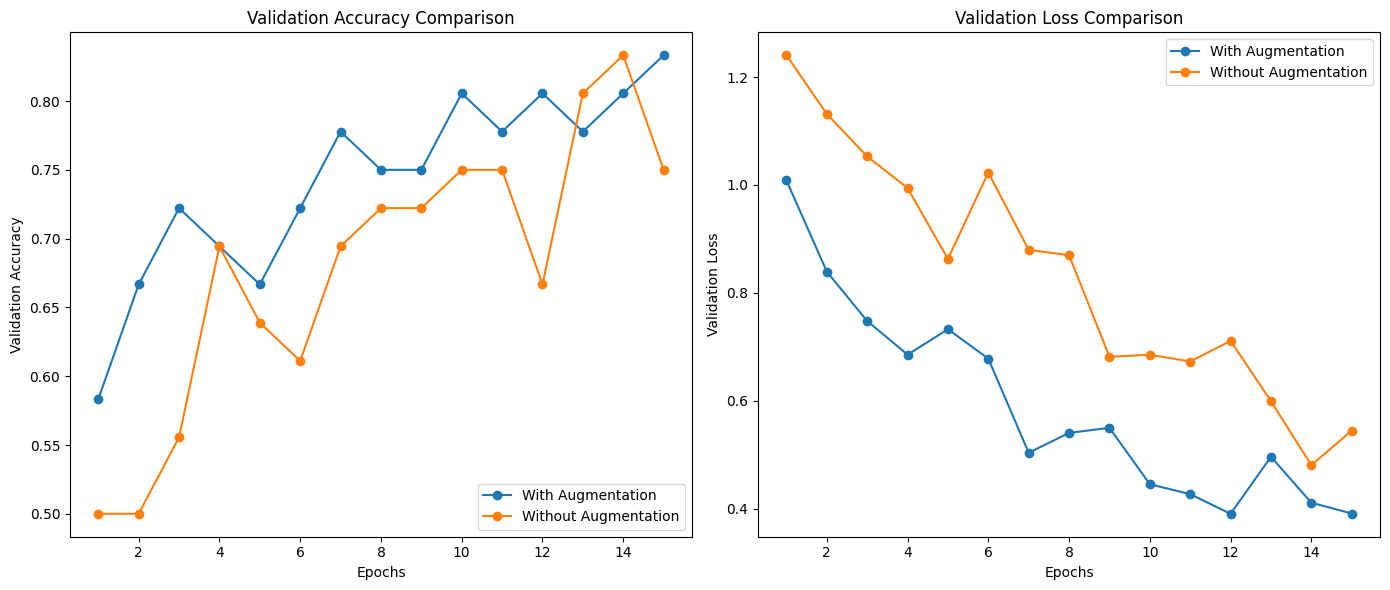

In [23]:
import matplotlib.pyplot as plt

# Validation metrics for both models (replace with actual data)
with_augmentation = {
    "accuracy": [0.5833, 0.6667, 0.7222, 0.6944, 0.6667, 0.7222, 0.7778, 0.7500, 0.7500, 0.8056, 0.7778, 0.8056, 0.7778, 0.8056, 0.8333],
    "loss": [1.0084, 0.8392, 0.7477, 0.6852, 0.7325, 0.6779, 0.5035, 0.5402, 0.5497, 0.4451, 0.4267, 0.3903, 0.4959, 0.4109, 0.3908]
}

without_augmentation = {
    "accuracy": [0.5000, 0.5000, 0.5556, 0.6944, 0.6389, 0.6111, 0.6944, 0.7222, 0.7222, 0.7500, 0.7500, 0.6667, 0.8056, 0.8333, 0.7500],
    "loss": [1.2403, 1.1315, 1.0527, 0.9942, 0.8627, 1.0229, 0.8795, 0.8697, 0.6814, 0.6851, 0.6726, 0.7108, 0.5990, 0.4804, 0.5445]
}

# Epochs
epochs = range(1, len(with_augmentation["accuracy"]) + 1)

# Visualization
plt.figure(figsize=(14, 6))

# Validation Accuracy Comparison
plt.subplot(1, 2, 1)
plt.plot(epochs, with_augmentation["accuracy"], label="With Augmentation", marker='o')
plt.plot(epochs, without_augmentation["accuracy"], label="Without Augmentation", marker='o')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend(loc='lower right')

# Validation Loss Comparison
plt.subplot(1, 2, 2)
plt.plot(epochs, with_augmentation["loss"], label="With Augmentation", marker='o')
plt.plot(epochs, without_augmentation["loss"], label="Without Augmentation", marker='o')
plt.title('Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [31]:
# Define individual augmentation generators
data_gen_rotation = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=15,
    validation_split=0.2
)

data_gen_zoom = ImageDataGenerator(
    rescale=1.0 / 255,
    zoom_range=0.15,
    validation_split=0.2
)

data_gen_shift = ImageDataGenerator(
    rescale=1.0 / 255,
    width_shift_range=0.15,
    height_shift_range=0.15,
    validation_split=0.2
)

# Evaluate each technique
augmentation_methods = {
    "Rotation": data_gen_rotation,
    "Zoom": data_gen_zoom,
    "Shift": data_gen_shift
}

for method, data_gen in augmentation_methods.items():
    train_aug = data_gen.flow_from_directory(
        directory=str(data_dir),
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        subset='training'
    )
    val_aug = data_gen.flow_from_directory(
        directory=str(data_dir),
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        subset='validation'
    )

    model = create_model()
    history = model.fit(
        train_aug,
        validation_data=val_aug,
        epochs=15,
        callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
    )

    print(f"\nResults for {method}:")
    print(f"Validation Accuracy: {history.history['val_accuracy'][-1]}")
    print(f"Validation Loss: {history.history['val_loss'][-1]}")


Found 151 images belonging to 4 classes.
Found 36 images belonging to 4 classes.
Epoch 1/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 40s 5s/step - accuracy: 0.3193 - loss: 1.9988 - val_accuracy: 0.3889 - val_loss: 1.4614
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 290ms/step - accuracy: 0.4306 - loss: 1.5102 - val_accuracy: 0.5000 - val_loss: 1.1555
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 255ms/step - accuracy: 0.5240 - loss: 1.0660 - val_accuracy: 0.4444 - val_loss: 1.0061
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 249ms/step - accuracy: 0.5064 - loss: 1.0208 - val_accuracy: 0.5278 - val_loss: 0.9962
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 292ms/step - accuracy: 0.6290 - loss: 0.9513 - val_accuracy: 0.6667 - val_loss: 0.8666
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 244ms/step - accuracy: 0.6493 - loss: 0.8090 - val_accuracy: 0.7222 - val_loss: 0.7279
Epoch 7/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 216ms/step - accuracy: 0.6606 - loss: 0.7654 - val_accuracy: 0.6111 - val_loss: 0.7818
Epoch 8/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s